<a href="https://colab.research.google.com/github/caithmac/facedata/blob/main/06_PyTorch_Transfer_Learning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:

# Try to import the going_modular directory, download it from GitHub if it doesn't work
from going_modular.going_modular import data_setup, engine


In [2]:
import torch

In [3]:
torch.__version__

'2.3.1+cu118'

In [4]:
# Setup device agnostic code
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cpu'

In [5]:
# Setup device agnostic code
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cpu'

In [6]:
!nvidia-smi

zsh:1: command not found: nvidia-smi


In [11]:
try:
    from torchinfo import summary
except:
    print("[INFO] Couldn't find torchinfo... installing it.")
    %pip install -q torchinfo
    from torchinfo import summary
    
    

## 1. Get Data

In [7]:
import os
import zipfile

from pathlib import Path

import requests

# Setup path to data folder
data_path = Path("data/")
image_path = data_path / "facedata"

# If the image folder doesn't exist, download it and prepare it...
if image_path.is_dir():
    print(f"{image_path} directory exists.")
else:
    print(f"Did not find {image_path} directory, creating one...")
    image_path.mkdir(parents=True, exist_ok=True)

# Download face data
with open(data_path / "face_data.zip", "wb") as f:
    request = requests.get("https://github.com/caithmac/facedata/raw/main/face_data.zip")
    print("Downloading face data...")
    f.write(request.content)

# Unzip face data
with zipfile.ZipFile(data_path / "face_data.zip", "r") as zip_ref:
    print("Unzipping face data...")
    zip_ref.extractall(image_path)

# Remove zip file
os.remove(data_path / "face_data.zip")

data/facedata directory exists.
Unzipping face data...


In [8]:
# Setup train and testing paths
train_dir = image_path / "train"
test_dir = image_path / "test"

train_dir, test_dir

(PosixPath('data/facedata/train'), PosixPath('data/facedata/test'))

## 2. Create Datasets and Dataloader 

`data_setup.py` and the `create_dataloader()`

### 2.1 Transform for `torchvision.models`

In [14]:
from going_modular.going_modular import data_setup

In [15]:
from torchvision import transforms 

normalize = transforms.Normalize(mean = [0.485,0.456,0.406],
                                 std = [0.229,0.224,0.225])
manual_transforms = transforms.Compose([transforms.Resize((224,224)),
                                        transforms.ToTensor(),
                                        normalize])

In [56]:
import torchvision
torchvision.__version__

'0.18.1+cu118'

In [57]:
weights = torchvision.models.EfficientNet_B0_Weights.DEFAULT ## instead why not use face model 
weights

EfficientNet_B0_Weights.IMAGENET1K_V1

In [58]:
auto_transforms = weights.transforms()
auto_transforms

ImageClassification(
    crop_size=[224]
    resize_size=[256]
    mean=[0.485, 0.456, 0.406]
    std=[0.229, 0.224, 0.225]
    interpolation=InterpolationMode.BICUBIC
)

In [59]:
# Create training and testing DataLoaders as well as get a list of class names
train_dataloader, test_dataloader, class_names = data_setup.create_dataloaders(train_dir=train_dir,
                                                                               test_dir=test_dir,
                                                                               transform=auto_transforms, # resize, convert images to between 0 & 1 and normalize them
                                                                               batch_size=32) # set mini-batch size to 32

train_dataloader, test_dataloader, class_names

(<torch.utils.data.dataloader.DataLoader at 0x7f2ae0279240>,
 ['Hugh_Jackman', 'Megan_Fox', 'Scarlett_Johansson', 'pratik'])

In [60]:
# NEW: Setup the model with pretrained weights and send it to the target device (torchvision v0.13+)
weights = torchvision.models.EfficientNet_B0_Weights.DEFAULT # .DEFAULT = best available weights 
model = torchvision.models.efficientnet_b0(weights=weights).to(device)

#model # uncomment to output (it's very long)

### 3.4 Freezing the base model and changing the output layer to suit our needs 

With a feature extractor model 

In [61]:
for param in model.features.parameters():
    param.requires_grad = False
    

In [62]:
# Set the manual seeds
torch.manual_seed(42)
torch.cuda.manual_seed(42)

# Get the length of class_names (one output unit for each class)
output_shape = len(class_names)

# Recreate the classifier layer and seed it to the target device
model.classifier = torch.nn.Sequential(
    torch.nn.Dropout(p=0.2, inplace=True), 
    torch.nn.Linear(in_features=1280, 
                    out_features=output_shape, # same number of output units as our number of classes
                    bias=True)).to(device)

## 4. Train Model

In [63]:
from torch import nn

loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr = 0.001)


In [64]:
# Set the random seeds


# Start the timer
from timeit import default_timer as timer 
start_time = timer()

# Setup training and save the results
results = engine.train(model=model,
                       train_dataloader=train_dataloader,
                       test_dataloader=test_dataloader,
                       optimizer=optimizer,
                       loss_fn=loss_fn,
                       epochs=100,
                       device=device)

# End the timer and print out how long it took
end_time = timer()
print(f"[INFO] Total training time: {end_time-start_time:.3f} seconds")

  0%|          | 0/100 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 1.4631 | train_acc: 0.2656 | test_loss: 1.3507 | test_acc: 0.2875
Epoch: 2 | train_loss: 1.3667 | train_acc: 0.3031 | test_loss: 1.3485 | test_acc: 0.2625
Epoch: 3 | train_loss: 1.3298 | train_acc: 0.3719 | test_loss: 1.3087 | test_acc: 0.3250
Epoch: 4 | train_loss: 1.2237 | train_acc: 0.4594 | test_loss: 1.2338 | test_acc: 0.3875
Epoch: 5 | train_loss: 1.2179 | train_acc: 0.4562 | test_loss: 1.2438 | test_acc: 0.4125
Epoch: 6 | train_loss: 1.1640 | train_acc: 0.5000 | test_loss: 1.2180 | test_acc: 0.4125
Epoch: 7 | train_loss: 1.1368 | train_acc: 0.5219 | test_loss: 1.3356 | test_acc: 0.3500
Epoch: 8 | train_loss: 1.0832 | train_acc: 0.5875 | test_loss: 1.4707 | test_acc: 0.3000
Epoch: 9 | train_loss: 1.0742 | train_acc: 0.5625 | test_loss: 1.3662 | test_acc: 0.3375
Epoch: 10 | train_loss: 1.0318 | train_acc: 0.6000 | test_loss: 1.3492 | test_acc: 0.3250
Epoch: 11 | train_loss: 0.9876 | train_acc: 0.6438 | test_loss: 1.2924 | test_acc: 0.3250
Epoch: 12 | train_l

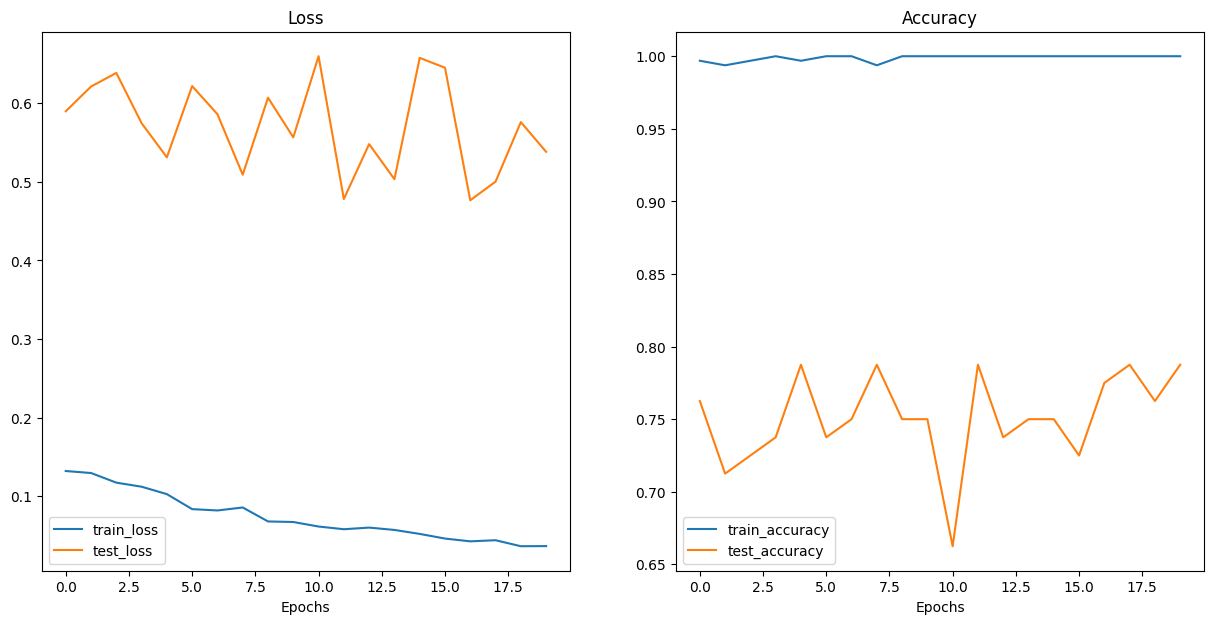

In [49]:
## 5. Evaluation model by plotting loss curve
# Get the plot_loss_curves() function from helper_functions.py, download the file if we don't have it
try:
    from helper_functions import plot_loss_curves
except:
    print("[INFO] Couldn't find helper_functions.py, downloading...")
    with open("helper_functions.py", "wb") as f:
        import requests
        request = requests.get("https://raw.githubusercontent.com/mrdbourke/pytorch-deep-learning/main/helper_functions.py")
        f.write(request.content)
    from helper_functions import plot_loss_curves

# Plot the loss curves of our model
plot_loss_curves(results)


In [50]:
from typing import List, Tuple

from PIL import Image

# 1. Take in a trained model, class names, image path, image size, a transform and target device
def pred_and_plot_image(model: torch.nn.Module,
                        image_path: str, 
                        class_names: List[str],
                        image_size: Tuple[int, int] = (224, 224),
                        transform: torchvision.transforms = None,
                        device: torch.device=device):
    
    
    # 2. Open image
    img = Image.open(image_path)

    # 3. Create transformation for image (if one doesn't exist)
    if transform is not None:
        image_transform = transform
    else:
        image_transform = transforms.Compose([
            transforms.Resize(image_size),
            transforms.ToTensor(),
            transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                 std=[0.229, 0.224, 0.225]),
        ])

    ### Predict on image ### 

    # 4. Make sure the model is on the target device
    model.to(device)

    # 5. Turn on model evaluation mode and inference mode
    model.eval()
    with torch.inference_mode():
      # 6. Transform and add an extra dimension to image (model requires samples in [batch_size, color_channels, height, width])
      transformed_image = image_transform(img).unsqueeze(dim=0)

      # 7. Make a prediction on image with an extra dimension and send it to the target device
      target_image_pred = model(transformed_image.to(device))

    # 8. Convert logits -> prediction probabilities (using torch.softmax() for multi-class classification)
    target_image_pred_probs = torch.softmax(target_image_pred, dim=1)

    # 9. Convert prediction probabilities -> prediction labels
    target_image_pred_label = torch.argmax(target_image_pred_probs, dim=1)

    # 10. Plot image with predicted label and probability 
    plt.figure()
    plt.imshow(img)
    plt.title(f"Pred: {class_names[target_image_pred_label]} | Prob: {target_image_pred_probs.max():.3f}")
    plt.axis(False);

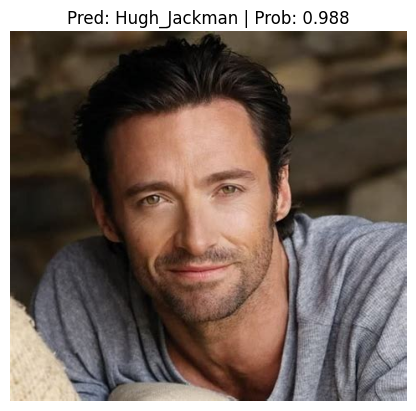

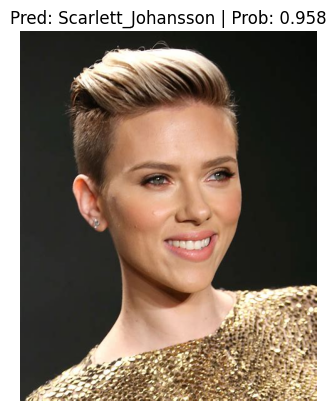

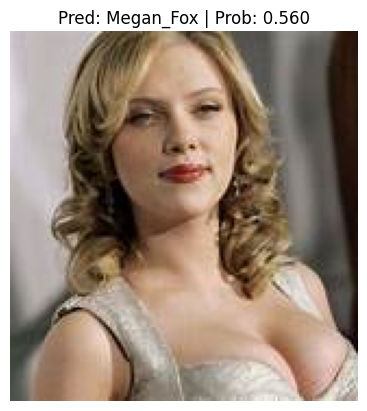

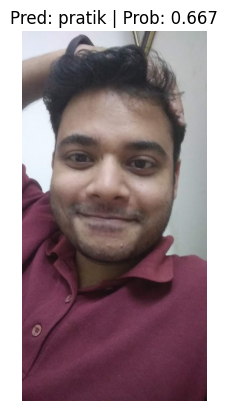

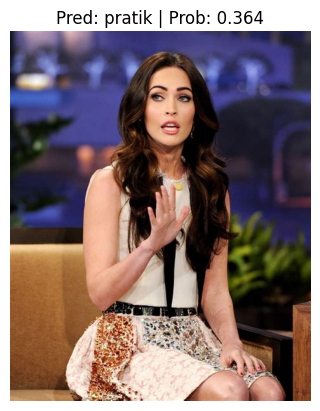

In [55]:
# Get a random list of image paths from test set
import random
import matplotlib.pyplot as plt
num_images_to_plot = 5
test_image_path_list = list(Path(test_dir).glob("*/*.jpg")) # get list all image paths from test data 
test_image_path_sample = random.sample(population=test_image_path_list, # go through all of the test image paths
                                       k=num_images_to_plot) # randomly select 'k' image paths to pred and plot

# Make predictions on and plot the images
for image_path in test_image_path_sample:
    pred_and_plot_image(model=model, 
                        image_path=image_path,
                        class_names=class_names,
                        # transform=weights.transforms(), # optionally pass in a specified transform from our pretrained model weights
                        image_size=(224, 224))

In [2]:
pip install deepface


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 45.4/45.4 kB 5.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 105.5/105.5 kB 12.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 101.7/101.7 kB 9.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.4/84.4 kB 11.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 53.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.3/2.3 MB 63.2 MB/s eta 0:00:00:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.5/62.5 MB 50.9 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 589.8/589.8 MB 10.5 MB/s eta 0:00:0000:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 57.5/57.5 kB 4.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.3/5.3 MB 88.7 MB/s eta 0:00:00ta 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.5/24.5 MB 79.4 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 72.6 MB/s eta 0:00:00
   ━━━━